In [7]:
import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import seaborn as sns

## Load data

In [9]:
annotation_df = pd.read_csv("data/ann_unfiltered.csv", index_col=0)

expression_df = pd.read_csv("data/log_tpms_from_fpkm_hgnc_unfiltered.csv", index_col=0)

# Show the column names
print("Annotation columns:\n", annotation_df.columns)

# Show unique value counts for each column (up to 20 values each)
for col in annotation_df.columns:
    unique_vals = annotation_df[col].unique()
    print(f"\nColumn: {col} — Unique values: {len(unique_vals)}")
    print(unique_vals[:20])  # show up to first 20 values


Annotation columns:
 Index(['tissue', 'time point', 'treatment response', 'patient_id',
       'sample_title', 'gsm_id'],
      dtype='object')

Column: tissue — Unique values: 1
['primary tumor (colorectum)']

Column: time point — Unique values: 2
['post-treatment' 'pre-treatment']

Column: treatment response — Unique values: 3
['non-PD' 'unknown' 'PD']

Column: patient_id — Unique values: 52
[ 1  2  3  4  6  8 28 29 32  7 12 13 10 11 14 15 16 61  9 18]

Column: sample_title — Unique values: 78
['POST-R-001' 'PAIR-R-001-pre' 'POST-R-002' 'PAIR-R-002' 'PAIR-R-003'
 'PRE-R-001' 'PAIR-R-004' 'POST-R-004' 'PAIR-R-006' 'PRE-R-002' 'PAIR-04'
 'PAIR-R-008' 'PAIR-28' 'PAIR-29' 'PAIR-32' 'PRE-R-006' 'PRE-R-007'
 'PAIR-R-012' 'PAIR-R-013' 'POST-R-010']

Column: gsm_id — Unique values: 81
['GSM5575333' 'GSM5575334' 'GSM5575336' 'GSM5575337' 'GSM5575339'
 'GSM5575342' 'GSM5575343' 'GSM5575347' 'GSM5575349' 'GSM5575350'
 'GSM5575351' 'GSM5575356' 'GSM5575359' 'GSM5575360' 'GSM5575361'
 'GSM5575363

## Create PCA plot by merging two expressions with annotations

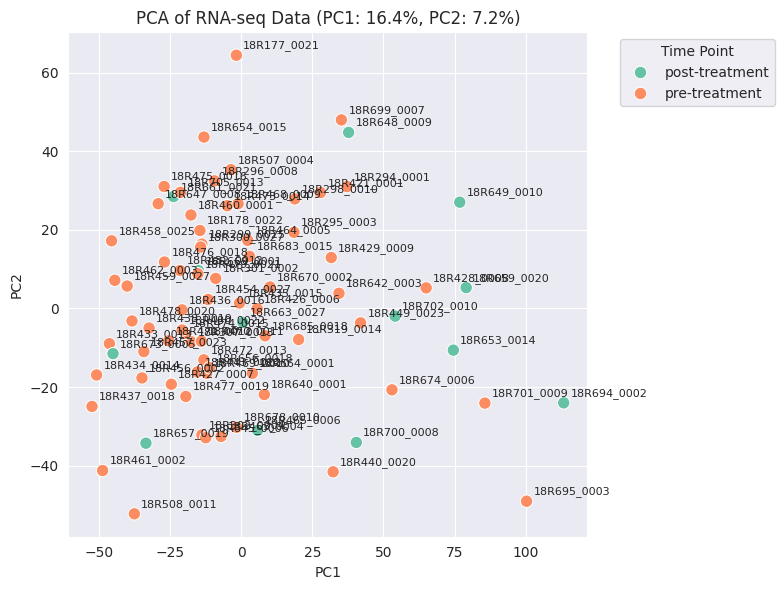

In [10]:
# Merge expression and metadata on 'sample_id'
merged_df = pd.merge(expression_df, annotation_df, left_index=True, right_index=True, how='inner')

# Separate numeric (genes) and metadata
gene_columns = [col for col in expression_df.columns if col not in ['sample_id']]  # Exclude non-gene columns
expression_numeric = merged_df[gene_columns]
metadata = merged_df[['time point']]  # Or other metadata columns

# Step 1: Scale the gene expression data (genes are now columns!)
# scaler = StandardScaler()
# scaled_expression = scaler.fit_transform(expression_numeric)

# Step 2: PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(expression_numeric)

# Step 3: Create PCA DataFrame
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
pca_df['sample_id'] = merged_df.index.values  # Add sample IDs
pca_df['time point'] = merged_df['time point'].values  # Add time points

# Step 4: Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='time point', palette='Set2', s=80)
plt.title(f'PCA of RNA-seq Data (PC1: {pca.explained_variance_ratio_[0]*100:.1f}%, PC2: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Time Point', bbox_to_anchor=(1.05, 1), loc='upper left')
for i, row in pca_df.iterrows():
    plt.annotate(row['sample_id'], (row['PC1'], row['PC2']), xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.tight_layout()
plt.show()


# --- Outlier Detection ---

## Method 1: Mahalanobis Distance

In [11]:
cov_matrix = np.cov(pca_results.T)
mean_pc = np.mean(pca_results, axis=0)
inv_cov = np.linalg.inv(cov_matrix)
pca_df['mahalanobis_distance'] = [mahalanobis(x, mean_pc, inv_cov) for x in pca_results]

# Identify outliers (top 5% farthest)
threshold = np.percentile(pca_df['mahalanobis_distance'], 95)
outliers = pca_df[pca_df['mahalanobis_distance'] > threshold]
print("Outliers (Mahalanobis Distance > 95th percentile):")
print(outliers[['sample_id', 'time point', 'mahalanobis_distance']].sort_values('mahalanobis_distance', ascending=False))

Outliers (Mahalanobis Distance > 95th percentile):
      sample_id      time point  mahalanobis_distance
36  18R695_0003   pre-treatment              3.427632
7   18R694_0002  post-treatment              3.271617
18  18R177_0021   pre-treatment              2.675066
67  18R701_0009   pre-treatment              2.558154


## Method 2: Z-score (on PCs)

In [12]:
for pc in ['PC1', 'PC2']:
    pca_df[f'{pc}_zscore'] = (pca_df[pc] - pca_df[pc].mean()) / pca_df[pc].std()
zscore_outliers = pca_df[(np.abs(pca_df['PC1_zscore']) > 3) | (np.abs(pca_df['PC2_zscore']) > 3)]
print("\nOutliers (Z-score > |3|):")
print(zscore_outliers[['sample_id', 'time point', 'PC1_zscore', 'PC2_zscore']])


Outliers (Z-score > |3|):
     sample_id      time point  PC1_zscore  PC2_zscore
7  18R694_0002  post-treatment    3.115965   -0.997116
